## The model

#### Parameters and pre-computed values
Our formulation uses the following parameters, which are input into the function or pre-computed:
* $N$ the number of nodes, which is determined by the depth of a tree
* $P_t^L$ the set of left parents for leaf $t$. Only defined for the leaves.
* $P_t^R$ the set of right parents for leaf $t$. Only defined for the leaves.
* $P_m^d$ the single direct parent node for a given node $m$. Defined for every node except the root for which it is null.
* $C_m^L$ the set of all left child nodes for a given node $m$. In the code we only ever care about the intersection of this with the set of leaf nodes.
* $C_m^R$ the set of all right child nodes for a given node $m$. In the code we only ever care about the intersection of this with the set of leaf nodes.
* $B$ the set of branch (interior i.e. not leaf) nodes
* $L$ the set of leaf nodes
* $X \in \mathbb{R}^{n \times p}$ the data
* $l_s \in \{1,...,p\}$ the local sparsity parameter used to generate constraints
* $m_p \in \{0,1\}$ the Boolean specifying whether the formulation should consider margin
* $c_p$ the complexity parameter
* $K$ the number of clusters
* $\Omega$ the loss normalization factor defined as the loss from assigning all points to one cluster.

#### Model variables
* $a_{j,m}$ for $j \in \{1,...,p\}$ and $m \in B$ is the hyperplane coefficient for the $j$th variable at branch $m$
* $\hat{a}_{j,m}$ for $j \in \{1,...,p\}$ and $m \in B$ is the absolute value of $a$
* $b_m$ for $m \in B$ is the offset for the hyperplane at that split
* $z_{i,t} \in \{0,1\}$ denotes whether point $i$ is assigned to leaf $t$
* $\delta_{i,m}$ is the relative distance of observation $i$ from hyperplane $m$ 
* $\eta_m \leq 2$ is the margin for plane $m$. The constraint comes from normalizing the data.
* $d_m \in \{0,1\}$ determines whether hyperplane $m$ is included in the tree 
* $s_{j,m} \in \{0,1\}$ for $j \in \{1,...,p\}$ and $m \in B$ determines whether feature $j$ is included in hyperplane $m$
* $\mu_{k,j}$ is the L1-centroid of the $j$th feature in cluster $k$
* $\beta_{t,j}$ for $t \in L$ and $j \in \{1,...,p\}$ is the model's predicted value for the $j$th feature which is constrained to be a centroid
* $w_{k,t} \in \{0,1\}$ for $k \in \{1,...,K\}$ and $t \in L$ determines whether leaf $t$ is assigned to cluster $k$
* $f_{i,j}$ is the predicted value in the $j$th feature for point $i$ and is used to link the predicted values and centroids
* $\alpha_{t,j,k} \geq 0$ for $t \in L$, $j \in \{1,...,p\}$, and $k \in \{1,...,K\}$ is an auxiliary variable used to linearize $\mu_{k,j} w_{k,t}$
* $\gamma_{t,j,i} \geq 0$ for $t \in L$, $j \in \{1,...,p\}$, and point $i$ is an auxiliary variable used to linearize $\beta_{t,j}z_{i,t}$
* $\psi_{i,j} \geq 0$ is the loss in the $j$th feature for the $i$th point

#### Constraints
The following constraints are used to define the margin. The second and third constraint say that the margin is not affected by points that don't lie in a relevant leaf. In theory we would use the absolute value of distance in the second and third constraint but, because this has no upper bound and defines margin, which is substracted in the objective function, it leads to garbage solutions. Instead we use the knowledge that $\delta_{i,m}$ is negative for all left children and positive for all right children. These rely on the upper bound on margin that was defined above.
* $\sum_{j=1}^p(a_{j,m}X_{i,j}) - b_m = \delta_{i,m} \qquad \forall i=1,..,n; m \in B$ defines the relative distance to the plane i.e. defines $\delta_{i,m}$
* $\eta_m \leq -\delta_{i,m} + 2(1-z_{i,t}) \qquad \forall i;m,t \in C_m^L$
* $\eta_m \leq \delta_{i,m} + 2(1-z_{i,t}) \qquad \forall i;m,t \in C_m^R$

The following constraints enforce all the hyperplane splits for each point in each leaf. 
* $-1 \leq a_{j,m} \leq 1$ for all $j;m \in B$
* $\hat{a}_{j,m} \geq a_{j,m}$ and $\hat{a}_{j,m} \geq - a_{j,m}$ for all $j;m$ defines the absolute value
* $\sum_{j=1}^p(a_{j,m}X_{i,j}) - b_m + \epsilon \leq (2+\epsilon)(1-z_{i,t})$ for all $i;t \in B;m \in P_t^L$. This enforces the left branch splits.
* $\sum_{j=1}^p(a_{j,m}X_{i,j}) - b_m \geq -2(1-z_{i,t})$ for all $i;t \in B;m \in P_t^R$. This enforces the right branch splits. 

Make sure each point is assigned to one leaf
* $\sum_{t \in L} z_{i,j} = 1 \forall i$

Complexity constraints control the coefficients that can be used in a given hyperplan
* $\sum_{j=1}^p \leq l_s \forall m$ ensures that we don't use more features than allowed by the local sparsity parameter at each split $m$
* $\sum_{j=1}^p \hat{a}_{j,m} \leq d_m \forall m$ forces all coefficents to 0 if the split isn't used
* $-d_m \leq b_m \leq d_m \forall m$ forces the offset to be 0 if a split isn't used
* $-s_{j,m} \leq a_{j,m} \leq s_{j,m}$ for all $j,m$ forces $a$ to be 0 if the $j$th variable isn't used
* $s_{j,m} \leq d_m$ for all $j,m$ forces consistency between $d$ and $s$
* $d_m \leq d_{P_m^d}$ for all $m \in B \setminus \{1\}$ ensures that, if a split higher up in the tree is turned off, all splits below that are turned off

Cluster constraints.  N.B. THIS CONSTRAINT IS WRONG
* $\beta_{t,j} \leq d_{P_t^d}$ for all $t \in L, j$

Make sure that the prediction in each leaf is equal to the centroid of exactly one cluster
* $\alpha_{t,j,k} \leq w_{k,t}$ for all $t \in L, j \in \{1,...,p\}, k \in \{1,..,K\}$
* $\alpha_{t,j,k} \leq \mu_{k,j}$ for all $t \in L, j \in \{1,...,p\}, k \in \{1,..,K\}$
* $\alpha_{t,j,k} \geq \mu_{k,j} - (1-w_{k,t})$ for all $t \in L, j \in \{1,...,p\}, k \in \{1,..,K\}$
* $\sum_{k=1}^K w_{k,t} = 1$ for all $t \in L$ ensures each leaf is assigned to one cluster
* $\beta_{j,t} = \sum_{k=1}^K \alpha_{t,j,k}$

Connect the predictions to each point.
* $f_{i,j} = \sum_{t \in L} \gamma_{t,i,j}$ for all $i,j$
* $\gamma_{t,i,j} \leq z_{i,t}$ for all $t \in L,i,j$
* $\gamma_{t,i,j} \leq \beta_{t,j}$ for all $t \in L,i,j$
* $ \gamma_{t,i,j} \geq \beta_{t,j} - (1-z_{i,t})$ for all $t \in L,i,j$

Define the loss as the L1 distance from a point to its assigned centroid
* $\psi_{i,j} \geq f_{i,j} - X_{i,j}$ for all $i,j$
* $\psi_{i,j} \geq -f_{i,j} + X_{i,j}$ for all $i,j$

#### Objective function
The objective function includes loss from distance to the centroid, complexity, and margin:
$$ \min \frac{1}{\Omega} \sum_{i,j} \psi_{i,j} + c_p \sum_{j,m} s_{j,m} - \frac{m_p}{\Omega^2} \sum_{m} \eta_m $$

In [54]:
include("ClustTreeOpt.jl")
include("ClustTreeViz.jl")
include("ClustTreeSynthData.jl")
include("ClustTreeEval.jl");
using HDF5, JLD, Images

# Example

In [3]:
n = [5,5,5]+20
μ = 1.8*[[0,0.1],[0.5,1],[1,0.3]]
σ = [1,1,1]/2.2;

In [4]:
X = create_synthetic_data(n,μ,σ,seed=1234)
Y = synthetic_data_cluster_assignments(n);

In [5]:
df = readtable("iris.csv")
X_all = Matrix(df[:,1:4])
labels = df[:,5]
names = unique(labels)
Y_all = zeros(Int,size(X_all,1))
for i = 1:length(names)
    Y_all[labels .== names[i]] = i
end

downsampled = Y_all
prob = 0.1
srand(1234)
keep = rand(length(Y_all)) .<= prob

X_ds = X_all[keep,:]
Y_ds = Y_all[keep]

X = X_ds
Y = Y_ds;
print(length(Y))

c_p = 0
max_depth = 2
K = 3
local_sparsity = :all
warm_start = true
srand(1234);
# Takes about 100 minutes. Doesn't use x2

19

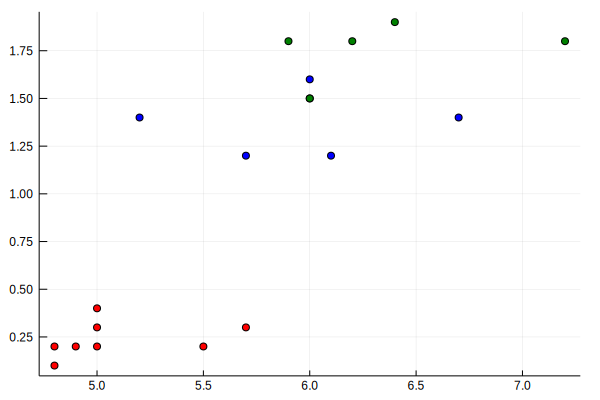

In [6]:
mcols = [:red, :blue, :green, :orange, 
    :pink, :yellow, :cyan, :magenta];
scatter(X[:,1],X[:,4], markercolor=mcols[Y], leg=false)

In [ ]:
c_p = 0
max_depth = 2
K = 3
local_sparsity = :all
warm_start = true
srand(1234);

In [ ]:
Input = Dict("c_p" => c_p, "md" => max_depth, 
    "K" => K, "seed" => 1234, "warm_start" => warm_start,
    "local_sparsity" => local_sparsity, "ns" => n, "μs" => μ, "σs" => σ);

#save("Test10.jld", "data", Input)
load("Test3.jld")["data"]

In [ ]:
@time result, starts = ClusterTree(X,c_p,max_depth,K; 
    warm_start = true, local_sparsity = local_sparsity);

# Solution Viz

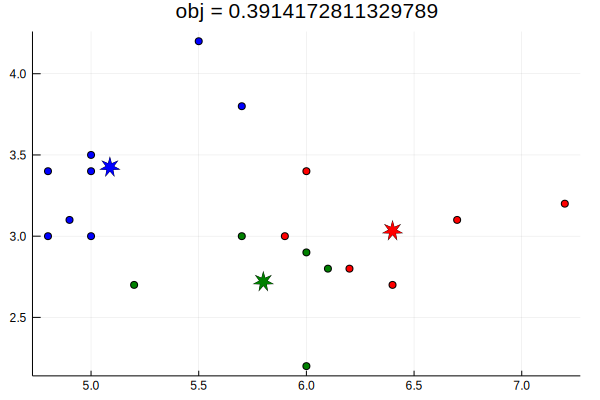

In [48]:
plot_cluster_tree(result,max_depth,X)

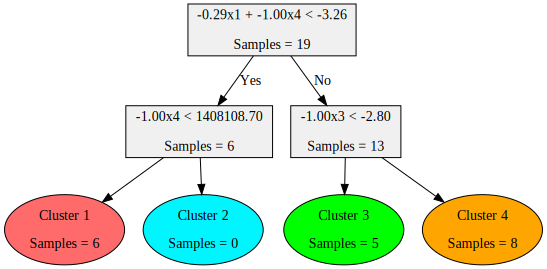

In [49]:
VizClusterTree(result)

# Warm Start Viz

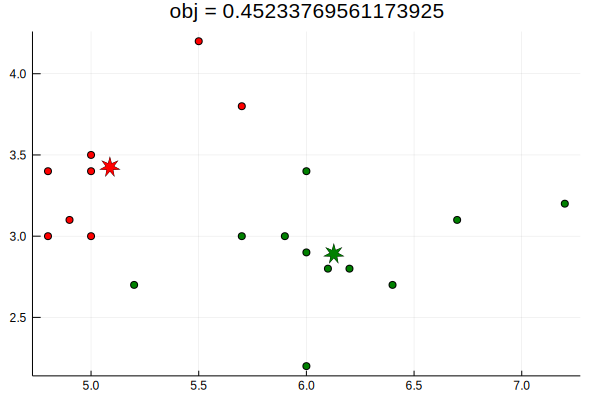

In [54]:
plot_cluster_tree(starts,max_depth, X)

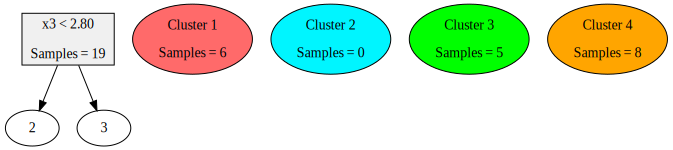

In [55]:
VizClusterTree(starts)

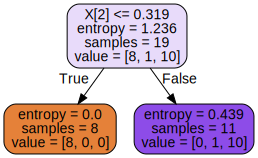

In [56]:
showtree(starts["tree"])

# K-means

  0.604227 seconds (305.87 k allocations: 14.926 MiB, 2.92% gc time)


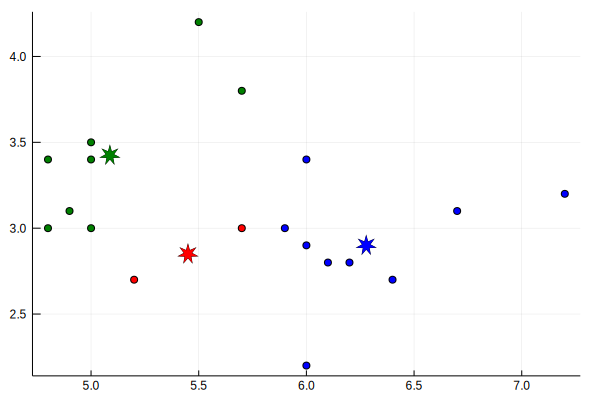

In [57]:
@time kmeans_clusters = kmeans(X',K)
mcols = [:red, :blue, :green, :orange, :pink, :yellow]
scatter(X[:,1],X[:,2], markercolor=mcols[assignments(kmeans_clusters)], leg=false)
scatter!(kmeans_clusters.centers[1,:],kmeans_clusters.centers[2,:], markercolor=mcols, m=[:star7], markersize = 10)

# Evaluation

In [ ]:
files = readdir("Test cases");
path = "Test cases/"
df = DataFrame()
for file in files
    println(file)
    data = load(string(path, file))["data"]
    X = create_synthetic_data(data["ns"],data["μs"],data["σs"],seed=data["seed"])
    Y = synthetic_data_cluster_assignments(data["ns"]);
    @time result = ClusterTree(X,data["c_p"],data["md"],data["K"]; 
    warm_start = true, local_sparsity = data["local_sparsity"]);
    df = vcat(df,evaluate_cluster_trees(X, Y, result; file_name = file))
    println()
end

Test1.jld
Academic license - for non-commercial use only
3099.403132 seconds (793.49 k allocations: 48.964 MiB, 0.00% gc time)
Status = Optimal
3134.423056 seconds (12.50 M allocations: 543.930 MiB, 0.03% gc time)

Test10.jld


In [ ]:
df

In [40]:
function evaluate_test_case(file; path = "Test cases/", TimeLimit = 3600)
    println(file)
    data = load(string(path, file))["data"]
    X = create_synthetic_data(data["ns"],data["μs"],data["σs"],seed=data["seed"])
    Y = synthetic_data_cluster_assignments(data["ns"]);
    @time result = ClusterTree(X,data["c_p"],data["md"],data["K"]; warm_start = true, 
                                        local_sparsity = data["local_sparsity"], TimeLimit = TimeLimit);
    return(evaluate_cluster_trees(X, Y, result; file_name = file))
end

evaluate_test_case (generic function with 1 method)

In [55]:
evaluate_test_case("Test5.jld")

Test5.jld
Academic license - for non-commercial use only
Status = Optimal
 15.208189 seconds (8.18 M allocations: 317.055 MiB, 2.53% gc time)


,file,n,p,accuracy,min_cluster_size,max_cluster_size,totalss,total_withinss,total_betweenss,time,status,objbound,objval,objgap
1,Test5.jld,27,2,1.0,9,9,18.357482403845154,1.1182969812379386,17.239185422607214,5.124853849411011,Optimal,0.7056431201265471,0.7056431201265471,0.0


In [56]:
data = load("Test cases/Test6.jld")["data"]

Dict{String,Any} with 9 entries:
  "local_sparsity" => 1
  "μs"             => Array{Float64,1}[[0.0, 0.0], [0.5, 0.5]]
  "warm_start"     => true
  "ns"             => [23, 23]
  "md"             => 2
  "seed"           => 1234
  "σs"             => [0.333333, 0.333333]
  "K"              => 2
  "c_p"            => 0

In [57]:
X = create_synthetic_data(data["ns"],data["μs"],data["σs"],seed=data["seed"])
Y = synthetic_data_cluster_assignments(data["ns"]);

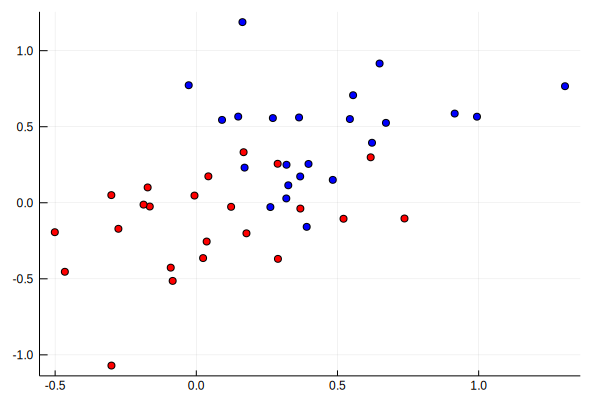

In [58]:
mcols = [:red, :blue, :green, :orange, 
    :pink, :yellow, :cyan, :magenta];
scatter(X[:,1],X[:,2], markercolor=mcols[Y], leg=false)

In [ ]:
@time result = ClusterTree(X,data["c_p"],data["md"],data["K"]; 
    warm_start = true, local_sparsity = data["local_sparsity"], TimeLimit = 20);

In [ ]:
evaluate_cluster_trees(X, Y, result)

In [ ]:
plot_cluster_tree(result,data["md"],X)

In [ ]:
img = VizClusterTree(result)